In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import TfidfModel
from gensim.models.phrases import Phrases, Phraser #–±–∏–≥—Ä–∞–º–º—ã –∏ —Ç—Ä–∏–≥—Ä–∞–º–º—ã. –Ω–µ –ø—Ä–∏–≥–æ–¥–∏–ª–∏—Å—å
from gensim.models import LdaModel, Nmf   #–∏—Å–ø–æ–ª—å–∑—É—é nmf

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from collections import Counter

In [3]:
def pretty_topics(model):
    for topic_id in range(model.num_topics):
        words = [word for word, _ in model.show_topic(topic_id)]
        print(f'–¢–µ–º–∞ {topic_id}: {', '.join(words)}')

def bow_structure(bow):
    return [[(dictionary[id], count) for id, count in line] for line in bow]

def dict_structure(dict):
    return (dict.token2id)

def get_main_topic(model, doc_bow):
    topics = model.get_document_topics(doc_bow)
    return max(topics, key=lambda x: x[1]) if topics else (100,100) 

In [5]:
df = pd.read_excel('all_posts_preprocessed.xlsx')

In [7]:
df.isna().any()

id        False
Posts     False
Date      False
Tokens    False
dtype: bool

In [9]:
texts = [text.split() for text in df['Tokens'].to_list()] 

In [11]:
print(f'–í—Å–µ–≥–æ —Ç–µ–∫—Å—Ç–æ–≤: {len(texts)}')

–í—Å–µ–≥–æ —Ç–µ–∫—Å—Ç–æ–≤: 15534


In [13]:
dictionary = corpora.Dictionary(texts)

In [15]:
print(f'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–≤ –≤ —Å–ª–æ–≤–∞—Ä–µ –¥–æ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏: {len(dictionary)}')

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–≤ –≤ —Å–ª–æ–≤–∞—Ä–µ –¥–æ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏: 29736


In [17]:
dictionary.filter_extremes(no_below = 15, no_above = 0.5) # tokens which are contained in at least 10 documents & in no more than 0.5 documents
print(f'–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–≤ –≤ —Å–ª–æ–≤–∞—Ä–µ –ø–æ—Å–ª–µ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏: {len(dictionary)}')

–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ª–æ–≤ –≤ —Å–ª–æ–≤–∞—Ä–µ –ø–æ—Å–ª–µ —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–∏: 3785


In [19]:
print('–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è —á–∞—Å—Ç–æ—Ç–∞ —Å–ª–æ–≤–∞ –≤ –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ö:', max(dictionary.dfs.values()))
print('–ú–∏–Ω–∏–º–∞–ª—å–Ω–∞—è —á–∞—Å—Ç–æ—Ç–∞ —Å–ª–æ–≤–∞ –≤ –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ö:', min(dictionary.dfs.values()), '\n')
print('–ß–∞—Å—Ç—ã–µ —Å–ª–æ–≤–∞:')
print(dictionary.most_common(50), '\n')

rare = [dictionary[i] for i in range(len(dictionary)) if dictionary.dfs[i] < 16]
print(f'–°–ª–æ–≤ —Å –º–∏–Ω–∏–º–∞–ª—å–Ω–æ–π –≤—Å—Ç—Ä–µ—á–∞–º–æ—Å—Ç—å—é: {len(rare)}')
print(rare[:20])

–ú–∞–∫—Å–∏–º–∞–ª—å–Ω–∞—è —á–∞—Å—Ç–æ—Ç–∞ —Å–ª–æ–≤–∞ –≤ –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ö: 3030
–ú–∏–Ω–∏–º–∞–ª—å–Ω–∞—è —á–∞—Å—Ç–æ—Ç–∞ —Å–ª–æ–≤–∞ –≤ –¥–æ–∫—É–º–µ–Ω—Ç–∞—Ö: 15 

–ß–∞—Å—Ç—ã–µ —Å–ª–æ–≤–∞:
[('—Ä–æ—Å—Å–∏—è', 3874), ('—Å–æ–æ–±—â–∏—Ç—å', 2958), ('–∑–∞—è–≤–∏—Ç—å', 2939), ('—Ä–æ—Å—Å–∏–π—Å–∫–∏–π', 2555), ('—É–∫—Ä–∞–∏–Ω–∞', 2233), ('—Å—Ç—Ä–∞–Ω–∞', 2065), ('–æ–±–ª–∞—Å—Ç—å', 1947), ('—á–µ–ª–æ–≤–µ–∫', 1803), ('–≤–æ–µ–Ω–Ω—ã–π', 1797), ('–≤—Å—É', 1728), ('—É–∫—Ä–∞–∏–Ω—Å–∫–∏–π', 1627), ('—Å—à–∞', 1583), ('–ø—Ä–µ–∑–∏–¥–µ–Ω—Ç', 1430), ('–ø—É—Ç–∏–Ω', 1407), ('–≥–ª–∞–≤–∞', 1262), ('—Å–≤–æ–π', 1172), ('–Ω–æ–≤—ã–π', 1077), ('—É–¥–∞—Ä', 1061), ('–º–æ—Å–∫–≤–∞', 992), ('–∫–∏–µ–≤', 989), ('—Å–ª–æ–≤–æ', 987), ('—Å—Ç–∞—Ç—å', 973), ('–æ—Ç–º–µ—Ç–∏—Ç—å', 915), ('–≤—Ä–µ–º—è', 913), ('—Ä–∞—Å—Å–∫–∞–∑–∞—Ç—å', 878), ('–¥–µ–Ω—å', 826), ('–∏–∑–∑', 824), ('—Ç—ã—Å—è—á–∞', 818), ('–¥–µ–ª–æ', 806), ('–≤–ª–∞—Å—Ç—å', 792), ('–≤–æ–π—Å–∫–æ', 788), ('–∞–º–µ—Ä–∏–∫–∞–Ω—Å–∫–∏–π', 783), ('—Å–∫–∞–∑–∞—Ç—å', 783), ('–≥–æ—Ä–æ–¥', 775), ('–ø

In [21]:
bow = [dictionary.doc2bow(text) for text in texts]

In [27]:
# —Ç—É—Ç –ª–¥–∞ –¥–ª—è –ø–æ—Å–ª–µ–¥—É—é—â–µ–≥–æ —Å—Ä–∞–≤–Ω–µ–Ω–∏—è
coherence_scores = []
for num_topics in tqdm(range(20, 40, 2)):
    lda_model = LdaModel(
        corpus=bow,
        id2word=dictionary,
        num_topics=num_topics,
        random_state=42
    )
    
    coherence_model = CoherenceModel(
        model=lda_model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 11/11 [06:06<00:00, 33.28s/it]


In [33]:
tfidf = TfidfModel(bow)
corpus_tfidf = tfidf[bow]

In [59]:
nmf_models = []
nmf_coherence = []
nums = range(20, 42, 2)

for n in tqdm(nums):
    nmf_model = Nmf(corpus=corpus_tfidf, id2word=dictionary, num_topics=n, random_state=42)
    nmf_models.append(nmf_model)
    
    nmf_coh_model = CoherenceModel(model = nmf_model, texts = texts, dictionary = dictionary, coherence='c_v')
    nmf_coh_score = nmf_coh_model.get_coherence()
    nmf_coherence.append(nmf_coh_score)

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 11/11 [03:01<00:00, 16.54s/it]


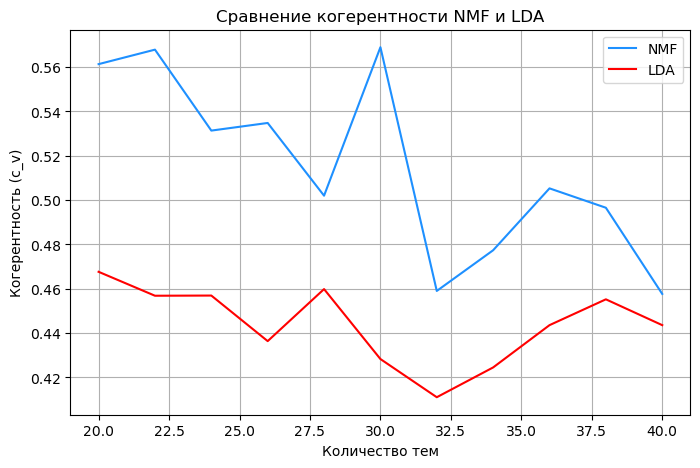

In [65]:
plt.figure(figsize = (8,5))

plt.plot(nums, nmf_coherence, color='dodgerblue', label='NMF')  
plt.plot(nums, coherence_scores, color='red', label='LDA') 
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–µ–º')
plt.ylabel('–ö–æ–≥–µ—Ä–µ–Ω—Ç–Ω–æ—Å—Ç—å (c_v)')
plt.title('–°—Ä–∞–≤–Ω–µ–Ω–∏–µ –∫–æ–≥–µ—Ä–µ–Ω—Ç–Ω–æ—Å—Ç–∏ NMF –∏ LDA')
plt.grid(True)
plt.legend();

In [61]:
max_nmf_coh = max(enumerate(nmf_coherence[:]), key = lambda x: x[1])[0]
nmf = nmf_models[max_nmf_coh]
print('–û–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–µ–º:')
nmf.num_topics

–û–ø—Ç–∏–º–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ç–µ–º:


30

In [63]:
max(nmf_coherence)

0.5690000642704139

In [57]:
print('–¢–µ–º—ã, –≤—ã–¥–µ–ª—è–µ–º—ã–µ NMF —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–π –∫–æ–≥–µ—Ä–µ–Ω—Ç–Ω–æ—Å—Ç—å—é: \n')
pretty_topics(nmf)

–¢–µ–º—ã, –≤—ã–¥–µ–ª—è–µ–º—ã–µ NMF —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–π –∫–æ–≥–µ—Ä–µ–Ω—Ç–Ω–æ—Å—Ç—å—é: 

–¢–µ–º–∞ 0: —É–¥–∞—Ä, –Ω–∞–Ω–µ—Å—Ç–∏, –≤—Å—É, —Ä–∞–∫–µ—Ç–Ω—ã–π, –ø–æ–¥–ø–æ–ª—å–µ, –∏–∑—Ä–∞–∏–ª—å—Å–∫–∏–π, –≤–æ–µ–Ω–Ω—ã–π, –∞–≤–∏–∞—Ü–∏—è, —Ö–µ–∑–±–æ–ª–ª, –º–∏–Ω–æ–±–æ—Ä–æ–Ω—ã
–¢–µ–º–∞ 1: –≤–∑—Ä—ã–≤, –ø—Ä–æ–≥—Ä–µ–º–µ—Ç—å, —Å–º–∏, —Ö–∞—Ä—å–∫–æ–≤, —Å–æ–æ–±—â–∏—Ç—å, –æ–¥–µ—Å—Å–∞, —Å–µ—Ä–∏—è, –≥–æ—Ä–æ–¥, –ø—Ä–æ–∏–∑–æ–π—Ç–∏, –¥–Ω–µ–ø—Ä–æ–ø–µ—Ç—Ä–æ–≤—Å–∫
–¢–µ–º–∞ 2: –ø–æ–≥–∏–±–Ω—É—Ç—å, –ø–æ—Å—Ç—Ä–∞–¥–∞—Ç—å, —á–∏—Å–ª–æ, —á–µ–ª–æ–≤–µ–∫, –æ–±—Å—Ç—Ä–µ–ª, —Å–∞–º–æ–ª—ë—Ç, –≤—ã—Ä–∞—Å—Ç–∏, —Ä–µ–±—ë–Ω–æ–∫, –±–µ–ª–≥–æ—Ä–æ–¥, –Ω–∞—Ö–æ–¥–∏—Ç—å—Å—è
–¢–µ–º–∞ 3: –¥–æ–ª–ª–∞—Ä, –º–∏–ª–ª–∏–∞—Ä–¥, –º–∏–ª–ª–∏–æ–Ω, –ø–æ–º–æ—â—å, –≤—ã—Ä–∞—Å—Ç–∏, —Ä—É–±–ª—å, –µ–≤—Ä–æ, –∞—Ç–∞–∫–∞, —Ç—ã—Å—è—á–∞, —á–∏—Å–ª–æ
–¢–µ–º–∞ 4: –∫—É—Ä—Å–∫–∏–π, –æ–±–ª–∞—Å—Ç—å, –≤—Å—É, —É–Ω–∏—á—Ç–æ–∂–∏—Ç—å, —Ç–µ—Ö–Ω–∏–∫–∞, –ø—É—Ç–∏–Ω, –ø—Ä–∏–≥—Ä–∞–Ω–∏—á–Ω—ã–π, —ç–∫–∏–ø–∞–∂, —Ä–∞–π–æ–Ω, —É–∫—Ä–∞–∏–Ω—Å–∫–∏–π
–¢–µ–º–∞ 5: –∑–∞–∫–æ–Ω, —Ä—É–±–ª—å, –ø–æ–¥–ø–∏

In [35]:
def get_main_topic(model, doc_bow):
    topics = model.get_document_topics(doc_bow)
    return max(topics, key=lambda x: x[1]) if topics else (100,100)   #—Ç–µ–º–∞ —Å –º–∞–∫—Å–∏–º–∞–ª—å–Ω–æ–π –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å—é

main_topics = [get_main_topic(nmf, doc) for doc in corpus_tfidf]

In [37]:
df['Topic_num'] = [i[0] for i in main_topics] #df = all_posts_preprocessed

In [43]:
df = df[df['Topic_num'] != 100]

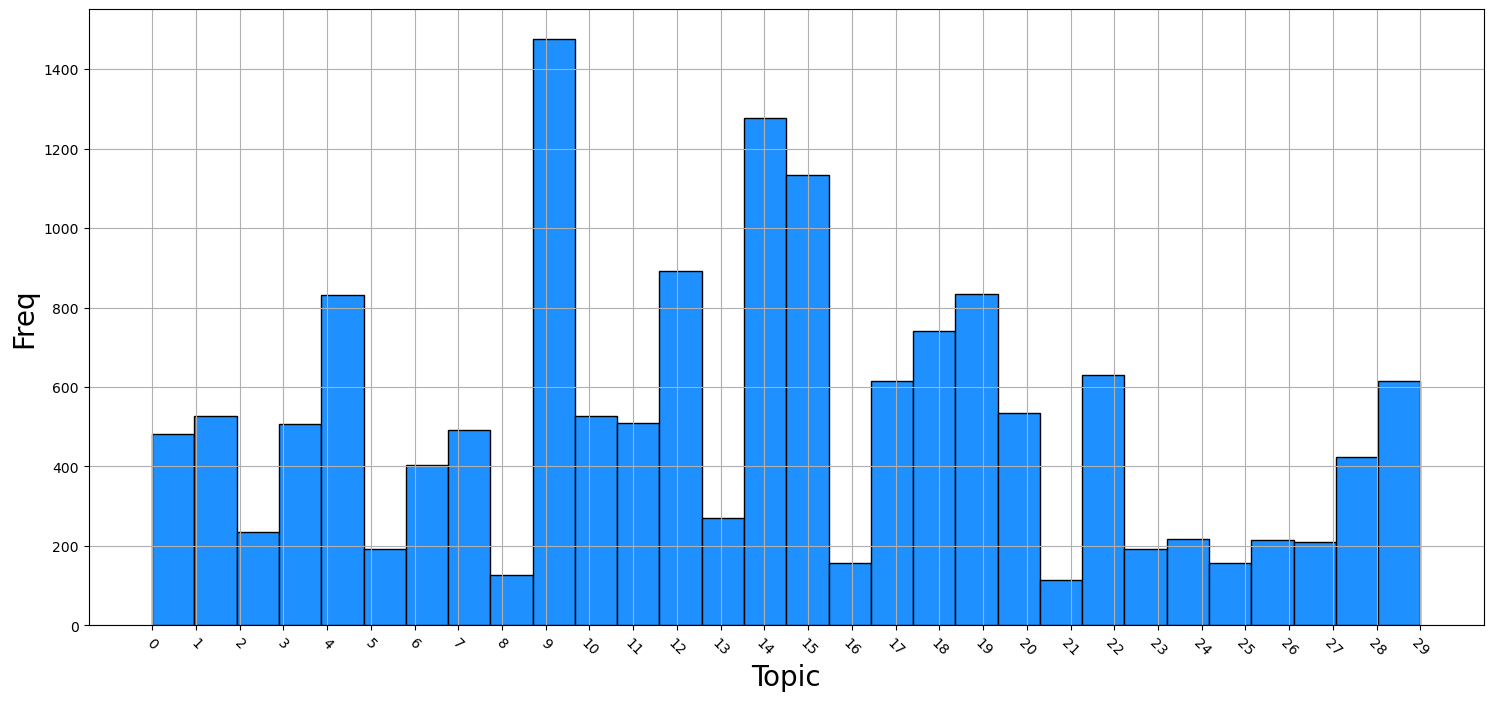

In [49]:
plt.figure(figsize = (18,8))
plt.hist(df['Topic_num'], bins = 30, color = 'dodgerblue', edgecolor = 'black')
plt.xlabel('Topic', size = 20)
plt.ylabel('Freq', size = 20)
plt.xticks(range(30), rotation  = -45)
plt.grid();

# –¥–æ–±–∞–≤–ª—è–µ–º —Ç–µ–º—ã –≤ –¥—Ñ

In [52]:
def set_topic(num):
    if num in [0,2,5,8,9,10,13,16,18,21,25,26,27]:
        return 'svo'
    if num in [7,12]:
        return 'usa'
    if num in [20,23]:
        return 'putin'
    if num in [1,22]:
        return 'middle_east'
    if num == 17:
        return 'soc_pol'
    if num == 4:
        return 'crime'
    if num == 6:
        return 'economics'
    if num == 11:
        return 'diplomacy'
    if num == 3:
        return 'protests'
    if num in [14,29]:
        return 'emergency'

In [56]:
df['Topic'] = df['Topic_num'].apply(lambda x: set_topic(x))

In [60]:
df = df.dropna()

In [64]:
df

id                                              Posts  \
0      47017418  #–ü–†–Ø–ú–ê–Ø–¢–†–ê–ù–°–õ–Ø–¶–ò–Ø \n–ú–æ—Å–∫–≤–∏—á–∏ –∏ –≥–æ—Å—Ç–∏ —Å—Ç–æ–ª–∏—Ü—ã –æ...   
3      47017217  –ù–∞ –ø–æ–±–µ—Ä–µ–∂—å–µ –ê–Ω–∞–ø—ã –≤—ã—è–≤–∏–ª–∏ –ø–æ–≤—Ç–æ—Ä–Ω—ã–µ –≤—ã–±—Ä–æ—Å—ã –Ω...   
5      47017037  –í–ª–∞–¥–∏–º–∏—Ä –ü—É—Ç–∏–Ω –∑–∞—Å–ª—É—à–∞–ª –¥–æ–∫–ª–∞–¥—ã –æ —Ö–æ–¥–µ —Å–ø–µ—Ü–∏–∞–ª...   
6      47016960  –†–æ–≤–Ω–æ 30 –ª–µ—Ç –Ω–∞–∑–∞–¥ —Ñ–µ–¥–µ—Ä–∞–ª—å–Ω—ã–µ –≤–æ–π—Å–∫–∞ –≤–æ—à–ª–∏ –≤ ...   
13     47016417  –£ —Ä–æ—Å—Å–∏–π—Å–∫–∏—Ö –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª–µ–π Telegram –≤ —Å–∏—Ç—É–∞—Ü–∏–∏...   
...         ...                                                ...   
15526  44452766  –¢–∞–∫, –Ω–∞–ø—Ä–∏–º–µ—Ä, –ø–æ –æ–±—É—á–µ–Ω–∏—é –¥–µ—Ç–µ–π –º–æ–∂–Ω–æ –±—É–¥–µ—Ç –∑...   
15527  44452573  –õ–∏–¥–µ—Ä –ö–ù–î–† –Ω–∞ –Ω–æ–≤–æ–≥–æ–¥–Ω–µ–π –≤—Å—Ç—Ä–µ—á–µ —Å –∫–æ–º–∞–Ω–¥–æ–≤–∞–Ω–∏...   
15529  44452087  UPD: –ü–æ–≥–∏–±–ª–∏ —á–µ—Ç—ã—Ä–µ —á–µ–ª–æ–≤–µ–∫–∞, —Å–æ–æ–±—â–∏–ª –ü—É—à–∏–ª–∏–Ω....   
15530  44451796  –û–Ω –≤—ã—Ä–∞—Å—Ç–µ—Ç –Ω–∞ 3 —Ç—ã—Å—è—á–∏ —Ä—É–±–ª–µ–π –∏ —Å–æ—Å—Ç–∞–≤–∏—Ç 19 2...   
15532  44451386  –í–ª–∞–¥–∏–º–∏—Ä –ü—É—Ç–∏–Ω –ø–æ–∑–¥—Ä–∞–≤–∏–ª —Ä–æ—Å—Å–∏—è–Ω —Å –ù–æ–≤—ã–º –≥–æ–¥–æ–º üéÑ‚≠ê   

             Date                                             Tokens  \
0      2024-12-31  –ø—Ä—è–º–∞—è—Ç—Ä–∞–Ω—Å–ª—è—Ü–∏—è –º–æ—Å–∫–≤–∏—á –≥–æ—Å—Ç—å —Å—Ç–æ–ª–∏—Ü–∞ –æ—Ç–º–µ—á–∞—Ç...   
3      2024-12-31  –ø–æ–±–µ—Ä–µ–∂—å–µ –∞–Ω–∞–ø–∞ –≤—ã—è–≤–∏—Ç—å –ø–æ–≤—Ç–æ—Ä–Ω—ã–π –≤—ã–±—Ä–æ—Å –Ω–µ—Ñ—Ç–µ...   
5      2024-12-31  –≤–ª–∞–¥–∏–º–∏—Ä –ø—É—Ç–∏–Ω –∑–∞—Å–ª—É—à–∞—Ç—å –¥–æ–∫–ª–∞–¥ —Ö–æ–¥ —Å–≤–æ –ø–æ–∑–¥—Ä–∞...   
6      2024-12-31  —Ä–æ–≤–Ω–æ –Ω–∞–∑–∞–¥ —Ñ–µ–¥–µ—Ä–∞–ª—å–Ω—ã–π –≤–æ–π—Å–∫–æ –≤–æ–π—Ç–∏ —Å—Ç–æ–ª–∏—Ü–∞ —á...   
13     2024-12-31  —Ä–æ—Å—Å–∏–π—Å–∫–∏–π –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—å —Å–∏—Ç—É–∞—Ü–∏—è –±–ª–æ–∫–∏—Ä–æ–≤–∫–∞ –∫–∞...   
...           ...                                                ...   
15526  2024-01-01  –Ω–∞–ø—Ä–∏–º–µ—Ä –æ–±—É—á–µ–Ω–∏–µ —Ä–µ–±—ë–Ω–æ–∫ –∑–∞—á–µ—Å—Ç—å —Ä–∞—Å—Ö–æ–¥ —Ç—ã—Å—è—á...   
15527  2024-01-01  –ª–∏–¥–µ—Ä –∫–Ω–¥—Ä –Ω–æ–≤–æ–≥–æ–¥–Ω–∏–π –≤—Å—Ç—Ä–µ—á–∞ –∫–æ–º–∞–Ω–¥–æ–≤–∞–Ω–∏–µ –∞—Ä–º...   
15529  2024-01-01          –ø–æ–≥–∏–±–Ω—É—Ç—å —á–µ—Ç—ã—Ä–µ —á–µ–ª–æ–≤–µ–∫ —Å–æ–æ–±—â–∏—Ç—å –ø—É—à–∏–ª–∏–Ω   
15530  2024-01-01  –≤—ã—Ä–∞—Å—Ç–∏ —Ç—ã—Å—è—á–∞ —Ä—É–±–ª—å —Å–æ—Å—Ç–∞–≤–∏—Ç—å —Ä—É–±–ª—å –ø—Ä–æ–∂–∏—Ç–æ—á–Ω...   
15532  2024-01-01          –≤–ª–∞–¥–∏–º–∏—Ä –ø—É—Ç–∏–Ω –ø–æ–∑–¥—Ä–∞–≤–∏—Ç—å —Ä–æ—Å—Å–∏—è–Ω–∏–Ω –Ω–æ–≤—ã–π   

       Topic_num        Topic  
0             23        putin  
3             14    emergency  
5             20        putin  
6              4        crime  
13            29    emergency  
...          ...          ...  
15526         17      soc_pol  
15527         22  middle_east  
15529         29    emergency  
15530         17      soc_pol  
15532         20        putin  

[12926 rows x 6 columns]

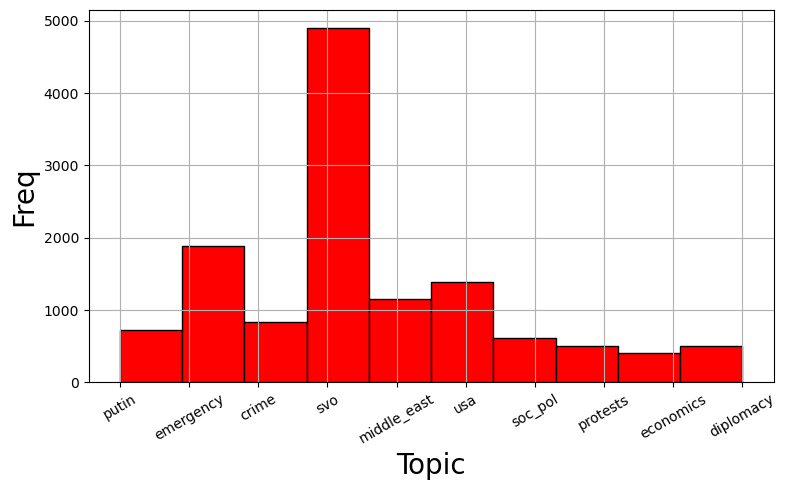

In [70]:
plt.figure(figsize = (8,5))
plt.hist(df['Topic'], bins = df['Topic'].nunique(), color = 'red', edgecolor = 'black')
plt.xlabel('Topic', size = 20)
plt.ylabel('Freq', size = 20)
plt.xticks(rotation= 30, ha = 'center') 
plt.grid()
plt.tight_layout() ;

–≤—ã–±–æ—Ä–∫–∞ –Ω–µ—Å–±–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∞–Ω–Ω–∞—è - –∫–ª–∞—Å—Å 'svo' —Å–∏–ª—å–Ω–æ –¥–æ–º–∏–Ω–∏—É—Ä–µ—Ç, –ø–æ—ç—Ç–æ–º—É –∏–∑ –ø–æ—Å—Ç–æ–≤ –ø–æ —ç—Ç–æ–π —Ç–µ–º–µ —è –±–µ—Ä—É –ª–∏—à—å –≤—ã–±–æ—Ä–∫—É, n = max –∏–∑ –æ—Å—Ç–∞–ª—å–Ω—ã—Ö –∫–ª–∞—Å—Å–æ–≤

In [73]:
not_svo = df[df['Topic'] != 'svo']

In [75]:
svo = df[df['Topic'] == 'svo']

In [79]:
len(df[df['Topic'] == 'emergency'])

1892

In [87]:
svo = svo.sample(n = len(df[df['Topic'] == 'emergency']), random_state = 2025)

In [93]:
result = pd.concat([svo, not_svo])

In [95]:
result

id                                              Posts  \
11342  45327845  –†–æ—Å—Å–∏–π—Å–∫–∏–π –≤–æ–µ–Ω–Ω—ã–π –≤–µ—Ä–Ω—É–ª—Å—è —Å —Ñ—Ä–æ–Ω—Ç–∞ –¥–æ–º–æ–π –∏ –ø...   
1482   46812980  –í—ã—Å–æ–∫–∞ –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å, —á—Ç–æ –¶–µ–Ω—Ç—Ä–æ–±–∞–Ω–∫ —Å–Ω–æ–≤–∞ –ø–æ–≤—ã—Å...   
9500   45643369  –ê–º–µ—Ä–∏–∫–∞–Ω—Å–∫–∏–π –ë–ü–õ–ê —Å–Ω–æ–≤–∞ –∑–∞–º–µ—Ç–∏–ª–∏ –Ω–∞–¥ –ß–µ—Ä–Ω—ã–º –º–æ...   
14919  44597230  –û–º—Å–∫–∏–µ —à–∫–æ–ª—å–Ω–∏–∫–∏ –Ω–∞–ø–∏—Å–∞–ª–∏ –ø–∏—Å—å–º–∞ –Ω–∞ —Ñ—Ä–æ–Ω—Ç. –í –Ω...   
634    46929347  –†–æ—Å—Å–∏–π—Å–∫–∏–µ –≤–æ–µ–Ω–Ω—ã–µ –æ—Å–≤–æ–±–æ–¥–∏–ª–∏ –Ω–∞—Å–µ–ª–µ–Ω–Ω—ã–π –ø—É–Ω–∫—Ç...   
...         ...                                                ...   
15526  44452766  –¢–∞–∫, –Ω–∞–ø—Ä–∏–º–µ—Ä, –ø–æ –æ–±—É—á–µ–Ω–∏—é –¥–µ—Ç–µ–π –º–æ–∂–Ω–æ –±—É–¥–µ—Ç –∑...   
15527  44452573  –õ–∏–¥–µ—Ä –ö–ù–î–† –Ω–∞ –Ω–æ–≤–æ–≥–æ–¥–Ω–µ–π –≤—Å—Ç—Ä–µ—á–µ —Å –∫–æ–º–∞–Ω–¥–æ–≤–∞–Ω–∏...   
15529  44452087  UPD: –ü–æ–≥–∏–±–ª–∏ —á–µ—Ç—ã—Ä–µ —á–µ–ª–æ–≤–µ–∫–∞, —Å–æ–æ–±—â–∏–ª –ü—É—à–∏–ª–∏–Ω....   
15530  44451796  –û–Ω –≤—ã—Ä–∞—Å—Ç–µ—Ç –Ω–∞ 3 —Ç—ã—Å—è—á–∏ —Ä—É–±–ª–µ–π –∏ —Å–æ—Å—Ç–∞–≤–∏—Ç 19 2...   
15532  44451386  –í–ª–∞–¥–∏–º–∏—Ä –ü—É—Ç–∏–Ω –ø–æ–∑–¥—Ä–∞–≤–∏–ª —Ä–æ—Å—Å–∏—è–Ω —Å –ù–æ–≤—ã–º –≥–æ–¥–æ–º üéÑ‚≠ê   

             Date                                             Tokens  \
11342  2024-04-17  —Ä–æ—Å—Å–∏–π—Å–∫–∏–π –≤–æ–µ–Ω–Ω—ã–π –≤–µ—Ä–Ω—É—Ç—å—Å—è —Ñ—Ä–æ–Ω—Ç –¥–æ–º–æ–π –ø–µ—Ä–≤—ã...   
1482   2024-12-02  –≤—ã—Å–æ–∫–∏–π –≤–µ—Ä–æ—è—Ç–Ω–æ—Å—Ç—å —Ü–µ–Ω—Ç—Ä–æ–±–∞–Ω–∫ —Å–Ω–æ–≤–∞ –ø–æ–≤—ã—Å–∏—Ç—å ...   
9500   2024-06-05  –∞–º–µ—Ä–∏–∫–∞–Ω—Å–∫–∏–π –±–ø–ª–∞ —Å–Ω–æ–≤–∞ –∑–∞–º–µ—Ç–∏—Ç—å —á—ë—Ä–Ω—ã–π –º–æ—Ä–µ —Å...   
14919  2024-01-17  –æ–º—Å–∫–∏–π —à–∫–æ–ª—å–Ω–∏–∫ –Ω–∞–ø–∏—Å–∞—Ç—å –ø–∏—Å—å–º–æ —Ñ—Ä–æ–Ω—Ç —Ä–µ–±—è—Ç–∞ –ø...   
634    2024-12-19  —Ä–æ—Å—Å–∏–π—Å–∫–∏–π –≤–æ–µ–Ω–Ω—ã–π –æ—Å–≤–æ–±–æ–¥–∏—Ç—å –Ω–∞—Å–µ–ª–∏—Ç—å –ø—É–Ω–∫—Ç –Ω...   
...           ...                                                ...   
15526  2024-01-01  –Ω–∞–ø—Ä–∏–º–µ—Ä –æ–±—É—á–µ–Ω–∏–µ —Ä–µ–±—ë–Ω–æ–∫ –∑–∞—á–µ—Å—Ç—å —Ä–∞—Å—Ö–æ–¥ —Ç—ã—Å—è—á...   
15527  2024-01-01  –ª–∏–¥–µ—Ä –∫–Ω–¥—Ä –Ω–æ–≤–æ–≥–æ–¥–Ω–∏–π –≤—Å—Ç—Ä–µ—á–∞ –∫–æ–º–∞–Ω–¥–æ–≤–∞–Ω–∏–µ –∞—Ä–º...   
15529  2024-01-01          –ø–æ–≥–∏–±–Ω—É—Ç—å —á–µ—Ç—ã—Ä–µ —á–µ–ª–æ–≤–µ–∫ —Å–æ–æ–±—â–∏—Ç—å –ø—É—à–∏–ª–∏–Ω   
15530  2024-01-01  –≤—ã—Ä–∞—Å—Ç–∏ —Ç—ã—Å—è—á–∞ —Ä—É–±–ª—å —Å–æ—Å—Ç–∞–≤–∏—Ç—å —Ä—É–±–ª—å –ø—Ä–æ–∂–∏—Ç–æ—á–Ω...   
15532  2024-01-01          –≤–ª–∞–¥–∏–º–∏—Ä –ø—É—Ç–∏–Ω –ø–æ–∑–¥—Ä–∞–≤–∏—Ç—å —Ä–æ—Å—Å–∏—è–Ω–∏–Ω –Ω–æ–≤—ã–π   

       Topic_num        Topic  
11342          9          svo  
1482           8          svo  
9500           5          svo  
14919          9          svo  
634            8          svo  
...          ...          ...  
15526         17      soc_pol  
15527         22  middle_east  
15529         29    emergency  
15530         17      soc_pol  
15532         20        putin  

[9914 rows x 6 columns]

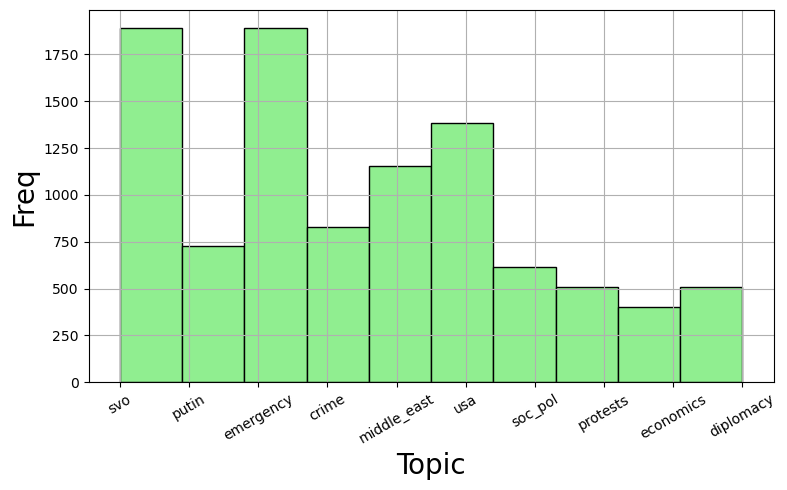

In [105]:
plt.figure(figsize = (8,5))
plt.hist(result['Topic'], bins = result['Topic'].nunique(), color = 'lightgreen', edgecolor = 'black')
plt.xlabel('Topic', size = 20)
plt.ylabel('Freq', size = 20)
plt.xticks(rotation= 30, ha = 'center') 
plt.grid()
plt.tight_layout() ;

In [99]:
result.to_excel('nmf_not_filtered.xlsx', index = False)